In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Dict, Optional, Union, Tuple


class FlexiNeck(nn.Module):
    """
    Neck modulaire et configurable pour différentes architectures de vision par ordinateur.
    Peut être utilisé pour la détection d'objets, la segmentation, la classification, etc.
    """
    def __init__(
        self,
        in_channels: List[int],
        out_channels: int = 256,
        use_fpn: bool = True,
        use_pan: bool = True,
        use_spp: bool = True,
        use_attention: bool = True,
        attention_type: str = "channel",
        attention_ratio: int = 4,
        fusion_type: str = "adaptive",
        interpolation_mode: str = "bilinear",
        output_size: Optional[Union[int, Tuple[int, int]]] = None,
        output_format: str = "multi_scale",
        normalize_outputs: bool = False
    ):
        """
        Initialise le neck modulaire.

        Args:
            in_channels: Liste des dimensions des features d'entrée [C2, C3, C4, C5] (du backbone)
            out_channels: Nombre de canaux de sortie
            use_fpn: Utiliser une Feature Pyramid Network
            use_pan: Utiliser une Path Aggregation Network
            use_spp: Utiliser le Spatial Pyramid Pooling
            use_attention: Utiliser un mécanisme d'attention
            attention_type: Type d'attention ("channel", "spatial", "hybrid")
            attention_ratio: Ratio de réduction pour les modules d'attention
            fusion_type: Type de fusion ("simple", "weighted", "adaptive")
            interpolation_mode: Mode d'interpolation ("nearest", "bilinear", "bicubic")
            output_size: Taille de sortie (optionnel, redimensionnement à cette taille)
            output_format: Format de sortie ("single", "multi_scale", "pyramid")
            normalize_outputs: Normaliser les sorties (utile pour certaines tâches)
        """
        super(FlexiNeck, self).__init__()

        self.in_channels = in_channels
        self.mid_channels = out_channels // 2
        self.out_channels = out_channels
        self.use_fpn = use_fpn
        self.use_pan = use_pan
        self.use_spp = use_spp
        self.use_attention = use_attention
        self.attention_type = attention_type
        self.attention_ratio = attention_ratio
        self.fusion_type = fusion_type
        self.interpolation_mode = interpolation_mode
        self.output_size = output_size
        self.output_format = output_format
        self.normalize_outputs = normalize_outputs

        # Configuration de l'interpolation
        self.align_corners = True if interpolation_mode in ["bilinear", "bicubic"] else None

        # Construire les composants requis
        self._build_layers()

    def _build_layers(self):
        """Construit les couches du neck en fonction de la configuration."""
        # 1. Projections latérales (toujours nécessaires)
        self.lateral_convs = nn.ModuleList()
        for c in self.in_channels:
            self.lateral_convs.append(nn.Conv2d(c, self.mid_channels, kernel_size=1))

        # 2. Modules FPN (Feature Pyramid Network)
        if self.use_fpn:
            self.fpn_convs = nn.ModuleList()
            for _ in range(len(self.in_channels) - 1):
                self.fpn_convs.append(
                    ConvBnRelu(self.mid_channels, self.mid_channels, kernel_size=3, padding=1)
                )

        # 3. Modules PAN (Path Aggregation Network)
        if self.use_pan:
            self.pan_convs = nn.ModuleList()
            for _ in range(len(self.in_channels) - 1):
                self.pan_convs.append(
                    ConvBnRelu(self.mid_channels, self.mid_channels, kernel_size=3, padding=1)
                )

        # 4. Module SPP (Spatial Pyramid Pooling)
        if self.use_spp:
            self.spp = EnhancedSPP(self.mid_channels)

        # 5. Module d'attention
        if self.use_attention:
            if self.attention_type == "channel":
                self.attention = ChannelAttention(self.mid_channels, reduction_ratio=self.attention_ratio)
            elif self.attention_type == "spatial":
                self.attention = SpatialAttention()
            elif self.attention_type == "hybrid":
                self.attention = HybridAttention(self.mid_channels, reduction_ratio=self.attention_ratio)

        # 6. Module de fusion (pour les skip connections)
        if self.fusion_type == "simple":
            self.fusion_module = SimpleFusion()
        elif self.fusion_type == "weighted":
            self.fusion_module = WeightedFusion(self.mid_channels)
        elif self.fusion_type == "adaptive":
            self.fusion_module = AdaptiveFusion(self.mid_channels)

        # 7. Couche de sortie
        if self.output_format == "single":
            self.output_conv = nn.Sequential(
                nn.Conv2d(self.mid_channels * len(self.in_channels),
                          self.out_channels, kernel_size=1),
                nn.BatchNorm2d(self.out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1)
            )
        else:
            self.output_convs = nn.ModuleList()
            for _ in range(len(self.in_channels)):
                self.output_convs.append(
                    nn.Sequential(
                        nn.Conv2d(self.mid_channels, self.out_channels, kernel_size=3, padding=1),
                        nn.BatchNorm2d(self.out_channels),
                        nn.ReLU(inplace=True)
                    )
                )

        # 8. Normalisation (optionnelle)
        if self.normalize_outputs:
            self.norms = nn.ModuleList()
            for _ in range(len(self.in_channels) if self.output_format != "single" else 1):
                self.norms.append(nn.GroupNorm(32, self.out_channels))

    def forward(self, features: List[torch.Tensor]) -> Union[torch.Tensor, List[torch.Tensor], Dict[str, torch.Tensor]]:
        """
        Traite les features extraites par le backbone.

        Args:
            features: Liste de tenseurs [C2, C3, C4, C5] du backbone

        Returns:
            Selon output_format:
                - "single": Un seul tenseur de features fusionnées
                - "multi_scale": Liste de tenseurs à différentes échelles
                - "pyramid": Dictionnaire de tenseurs avec noms des niveaux
        """
        assert len(features) == len(self.in_channels), \
            f"Nombre de features ({len(features)}) != nombre de canaux d'entrée ({len(self.in_channels)})"

        # Appliquer les projections latérales
        laterals = [conv(feat) for conv, feat in zip(self.lateral_convs, features)]

        # Top-down pathway (FPN)
        if self.use_fpn:
            for i in range(len(laterals) - 1, 0, -1):
                laterals[i-1] = laterals[i-1] + self._interpolate(
                    laterals[i],
                    size=laterals[i-1].shape[2:],
                    mode=self.interpolation_mode
                )
                laterals[i-1] = self.fpn_convs[i-1](laterals[i-1])

        # Bottom-up pathway (PAN)
        if self.use_pan:
            for i in range(len(laterals) - 1):
                laterals[i+1] = self.pan_convs[i](
                    laterals[i+1] + self._interpolate(
                        laterals[i],
                        size=laterals[i+1].shape[2:],
                        mode=self.interpolation_mode
                    )
                )

        # Appliquer SPP au premier niveau (plus haute résolution)
        if self.use_spp:
            laterals[0] = self.spp(laterals[0])

        # Appliquer la fusion aux niveaux extrêmes
        if self.fusion_type in ["weighted", "adaptive"]:
            laterals[-1] = self.fusion_module(laterals[0], laterals[-1])

        # Appliquer l'attention sur tous les niveaux
        if self.use_attention:
            laterals = [self.attention(feat) for feat in laterals]

        # Préparer les sorties selon le format demandé
        if self.output_format == "single":
            # Redimensionner tous les niveaux à la taille du premier (le plus grand)
            target_size = self.output_size if self.output_size else laterals[0].shape[2:]
            resized_feats = [
                self._interpolate(feat, size=target_size, mode=self.interpolation_mode)
                for feat in laterals
            ]

            # Concaténer tous les niveaux
            concat_feat = torch.cat(resized_feats, dim=1)
            output = self.output_conv(concat_feat)

            # Normaliser si nécessaire
            if self.normalize_outputs:
                output = self.norms[0](output)

            return output

        else:  # "multi_scale" ou "pyramid"
            outputs = []

            for i, feat in enumerate(laterals):
                # Appliquer les convolutions de sortie
                out = self.output_convs[i](feat)

                # Redimensionner si nécessaire
                if self.output_size:
                    out = self._interpolate(out, size=self.output_size, mode=self.interpolation_mode)

                # Normaliser si nécessaire
                if self.normalize_outputs:
                    out = self.norms[i](out)

                outputs.append(out)

            # Formater selon le type de sortie demandé
            if self.output_format == "multi_scale":
                return outputs
            else:  # "pyramid"
                return {f"p{i+2}": out for i, out in enumerate(outputs)}

    def _interpolate(self, x: torch.Tensor, size: Union[int, Tuple[int, int]], mode: str) -> torch.Tensor:
        """Helper pour interpoler les features avec les bons paramètres."""
        return F.interpolate(x, size=size, mode=mode, align_corners=self.align_corners)


# Composants modulaires pour le FlexiNeck
class ConvBnRelu(nn.Module):
    """Block de base: Convolution + BatchNorm + ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class EnhancedSPP(nn.Module):
    """Spatial Pyramid Pooling avec 3 niveaux."""
    def __init__(self, channels, reduction_factor=4):
        super(EnhancedSPP, self).__init__()
        reduced_channels = channels // reduction_factor

        # Pooling pyramidal à 3 niveaux
        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.BatchNorm2d(reduced_channels),
            nn.ReLU(inplace=True)
        )

        self.branch2 = nn.Sequential(
            nn.AdaptiveAvgPool2d(3),
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.BatchNorm2d(reduced_channels),
            nn.ReLU(inplace=True)
        )

        self.branch3 = nn.Sequential(
            nn.AdaptiveAvgPool2d(5),
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.BatchNorm2d(reduced_channels),
            nn.ReLU(inplace=True)
        )

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(channels + reduced_channels * 3, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        size = x.size()[2:]

        branch1 = self.branch1(x)
        branch1 = F.interpolate(branch1, size=size, mode='bilinear', align_corners=True)

        branch2 = self.branch2(x)
        branch2 = F.interpolate(branch2, size=size, mode='bilinear', align_corners=True)

        branch3 = self.branch3(x)
        branch3 = F.interpolate(branch3, size=size, mode='bilinear', align_corners=True)

        return self.fusion(torch.cat([x, branch1, branch2, branch3], dim=1))


class ChannelAttention(nn.Module):
    """Module d'attention sur les canaux."""
    def __init__(self, channels, reduction_ratio=4):
        super(ChannelAttention, self).__init__()

        reduced_channels = max(8, channels // reduction_ratio)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_mlp = nn.Sequential(
            nn.Conv2d(channels, reduced_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, channels, kernel_size=1)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))

        att = self.sigmoid(avg_out + max_out)
        return x * att


class SpatialAttention(nn.Module):
    """Module d'attention spatiale."""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Calculer les moyennes et max sur les canaux
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        # Concaténer et appliquer la convolution
        att = torch.cat([avg_out, max_out], dim=1)
        att = self.conv(att)
        att = self.sigmoid(att)

        return x * att


class HybridAttention(nn.Module):
    """Combinaison d'attention sur les canaux et spatiale."""
    def __init__(self, channels, reduction_ratio=4):
        super(HybridAttention, self).__init__()

        self.channel_attention = ChannelAttention(channels, reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x


class SimpleFusion(nn.Module):
    """Fusion simple par addition."""
    def __init__(self):
        super(SimpleFusion, self).__init__()

    def forward(self, x1, x2):
        # Redimensionner x1 à la taille de x2
        x1_resized = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)
        return x1_resized + x2


class WeightedFusion(nn.Module):
    """Fusion par somme pondérée avec coefficients appris."""
    def __init__(self, channels):
        super(WeightedFusion, self).__init__()

        self.weight_1 = nn.Parameter(torch.ones(1) * 0.5)
        self.weight_2 = nn.Parameter(torch.ones(1) * 0.5)

        self.fusion_conv = ConvBnRelu(channels, channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        # Redimensionner x1 à la taille de x2
        x1_resized = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)

        # Fusion pondérée
        fused = self.weight_1 * x1_resized + self.weight_2 * x2
        return self.fusion_conv(fused)


class AdaptiveFusion(nn.Module):
    """Fusion adaptative basée sur l'attention."""
    def __init__(self, channels):
        super(AdaptiveFusion, self).__init__()

        # Transformations des features
        self.transform_1 = ConvBnRelu(channels, channels, kernel_size=1)
        self.transform_2 = ConvBnRelu(channels, channels, kernel_size=1)

        # Génération de poids d'attention
        self.weight_generator = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels * 2, 2, kernel_size=1),
            nn.Softmax(dim=1)
        )

        # Fusion finale
        self.fusion_conv = ConvBnRelu(channels, channels, kernel_size=3, padding=1)

    def forward(self, x1, x2):
        # Redimensionner x1 à la taille de x2
        x1_resized = F.interpolate(x1, size=x2.shape[2:], mode='bilinear', align_corners=True)

        # Transformer les features
        x1_trans = self.transform_1(x1_resized)
        x2_trans = self.transform_2(x2)

        # Générer les poids d'attention
        concat = torch.cat([x1_trans, x2_trans], dim=1)
        weights = self.weight_generator(concat)

        # Appliquer les poids et fusionner
        fused = weights[:, 0:1, :, :] * x1_trans + weights[:, 1:2, :, :] * x2_trans
        return self.fusion_conv(fused)


# Exemple d'utilisation:
def example_usage():
    # Définir les dimensions des features provenant d'un backbone (ex: ResNet)
    in_channels = [256, 512, 1024, 2048]  # C2, C3, C4, C5

    # Pour la détection d'objets (format pyramide)
    neck_detection = FlexiNeck(
        in_channels=in_channels,
        out_channels=256,
        use_fpn=True,
        use_pan=True,
        use_spp=True,
        attention_type="channel",
        fusion_type="adaptive",
        interpolation_mode="bilinear",
        output_format="pyramid"
    )

    # Pour la segmentation (format single, une seule sortie haute résolution)
    neck_segmentation = FlexiNeck(
        in_channels=in_channels,
        out_channels=256,
        use_fpn=True,
        use_pan=False,  # Moins crucial pour la segmentation
        use_spp=True,
        attention_type="hybrid",  # Attention spatiale et sur les canaux
        fusion_type="adaptive",
        interpolation_mode="bilinear",
        output_size=(128, 128),  # Taille fixe de sortie
        output_format="single",
        normalize_outputs=True  # Utile pour la stabilité de l'entraînement
    )

    # Pour la classification (format multi_scale, plusieurs tailles de caractéristiques)
    neck_classification = FlexiNeck(
        in_channels=in_channels,
        out_channels=256,
        use_fpn=True,
        use_pan=False,
        use_spp=True,
        use_attention=True,
        attention_type="channel",  # L'attention sur les canaux est suffisante pour la classification
        fusion_type="simple",
        output_format="multi_scale"
    )

    # Exemple de forward pass (avec des tenseurs aléatoires)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Simuler les features d'entrée d'un backbone
    batch_size = 2
    features = [
        torch.randn(batch_size, 256, 64, 64).to(device),
        torch.randn(batch_size, 512, 32, 32).to(device),
        torch.randn(batch_size, 1024, 16, 16).to(device),
        torch.randn(batch_size, 2048, 8, 8).to(device)
    ]

    # Tester les différents necks
    out_detection = neck_detection(features)  # Dictionnaire {p2, p3, p4, p5}
    out_segmentation = neck_segmentation(features)  # Tenseur unique
    out_classification = neck_classification(features)  # Liste de tenseurs

    return (out_detection, out_segmentation, out_classification)

Utilisation de l'appareil: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


Utilisation de l'appareil: cuda

--- Test de la configuration: Simple FPN ---


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]
Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 1, Loss: 1.9700, Train Acc: 27.10%, Test Acc: 30.40%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]


Epoch 2, Loss: 1.6088, Train Acc: 39.16%, Test Acc: 39.90%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]


Epoch 3, Loss: 1.4477, Train Acc: 45.28%, Test Acc: 44.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]


Epoch 4, Loss: 1.3379, Train Acc: 50.06%, Test Acc: 40.90%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.26it/s]


Epoch 5, Loss: 1.2605, Train Acc: 52.90%, Test Acc: 52.20%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]



--- Test de la configuration: FPN + SPP ---


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Epoch 1, Loss: 1.9945, Train Acc: 24.10%, Test Acc: 37.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]


Epoch 2, Loss: 1.6353, Train Acc: 36.44%, Test Acc: 33.80%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]


Epoch 3, Loss: 1.5121, Train Acc: 43.50%, Test Acc: 40.20%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


Epoch 4, Loss: 1.4117, Train Acc: 46.80%, Test Acc: 46.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch 5, Loss: 1.3254, Train Acc: 49.64%, Test Acc: 48.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s]



--- Test de la configuration: FPN + Attention ---


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 1, Loss: 1.8830, Train Acc: 29.02%, Test Acc: 33.80%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


Epoch 2, Loss: 1.6048, Train Acc: 39.36%, Test Acc: 33.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 3, Loss: 1.4310, Train Acc: 45.82%, Test Acc: 36.40%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 4, Loss: 1.3082, Train Acc: 52.30%, Test Acc: 42.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


Epoch 5, Loss: 1.3718, Train Acc: 48.32%, Test Acc: 49.60%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]



--- Test de la configuration: FPN + PAN ---


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]


Epoch 1, Loss: 1.9367, Train Acc: 26.40%, Test Acc: 37.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


Epoch 2, Loss: 1.6061, Train Acc: 36.86%, Test Acc: 42.40%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.27it/s]


Epoch 3, Loss: 1.5003, Train Acc: 43.74%, Test Acc: 31.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


Epoch 4, Loss: 1.4263, Train Acc: 46.58%, Test Acc: 49.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]


Epoch 5, Loss: 1.3273, Train Acc: 50.98%, Test Acc: 50.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]



--- Test de la configuration: Full (FPN + PAN + SPP + Attention) ---


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.01it/s]


Epoch 1, Loss: 1.9239, Train Acc: 26.76%, Test Acc: 33.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.87it/s]


Epoch 2, Loss: 1.6903, Train Acc: 34.92%, Test Acc: 35.80%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


Epoch 3, Loss: 1.5206, Train Acc: 43.02%, Test Acc: 45.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.89it/s]


Epoch 4, Loss: 1.3862, Train Acc: 48.88%, Test Acc: 42.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


Epoch 5, Loss: 1.2899, Train Acc: 53.38%, Test Acc: 55.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.03it/s]



--- Résultats de comparaison ---

Configuration: Simple FPN
Accuracy finale: 52.20%
Temps d'inférence par image: 0.51 ms

Configuration: FPN + SPP
Accuracy finale: 48.00%
Temps d'inférence par image: 0.55 ms

Configuration: FPN + Attention
Accuracy finale: 49.60%
Temps d'inférence par image: 0.60 ms

Configuration: FPN + PAN
Accuracy finale: 50.70%
Temps d'inférence par image: 0.57 ms

Configuration: Full (FPN + PAN + SPP + Attention)
Accuracy finale: 55.50%
Temps d'inférence par image: 0.72 ms

=== Résumé des résultats ===

Meilleure configuration pour l'accuracy: Full (FPN + PAN + SPP + Attention) avec 55.50%
Configuration la plus rapide: Simple FPN avec 0.51 ms par image


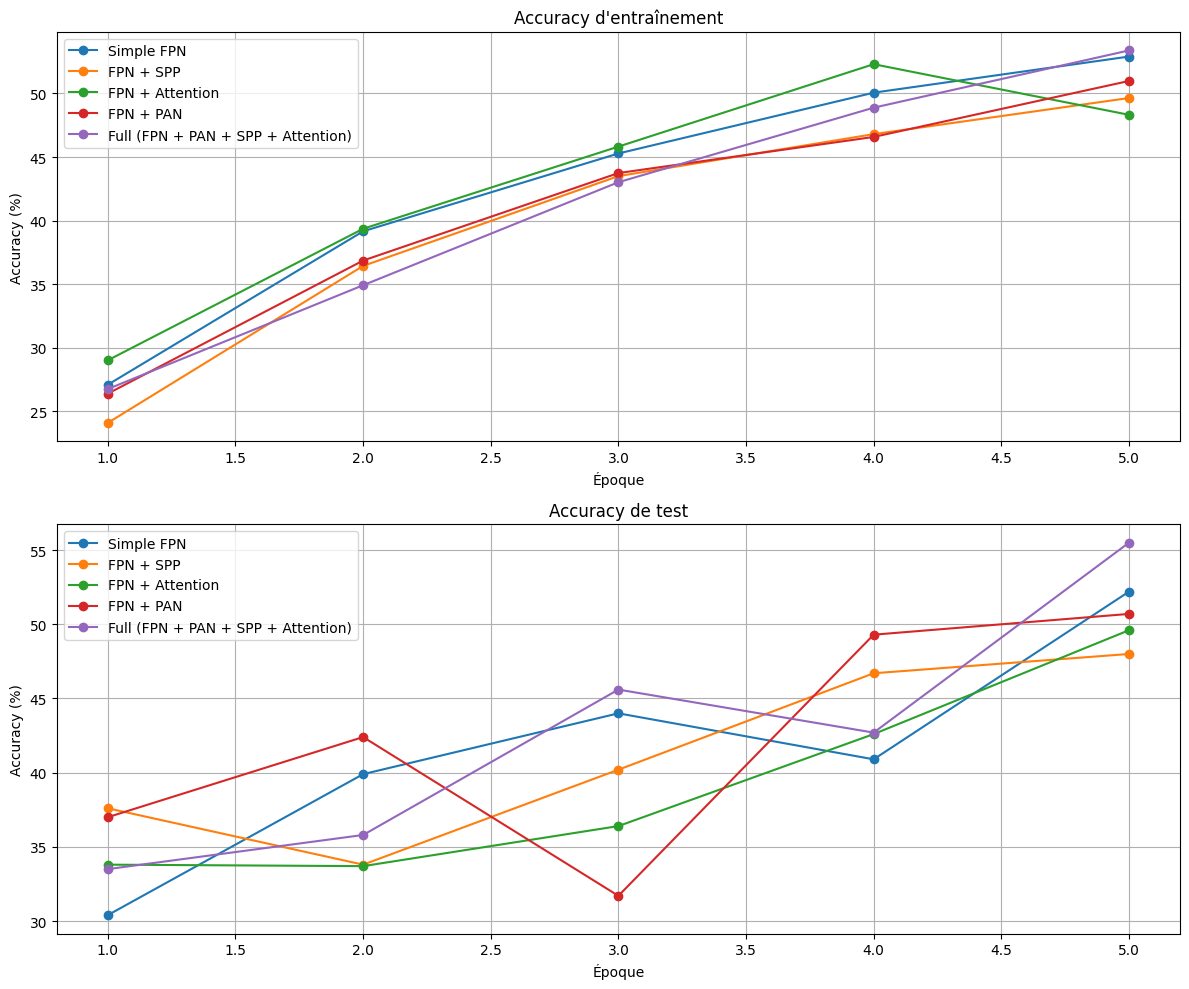

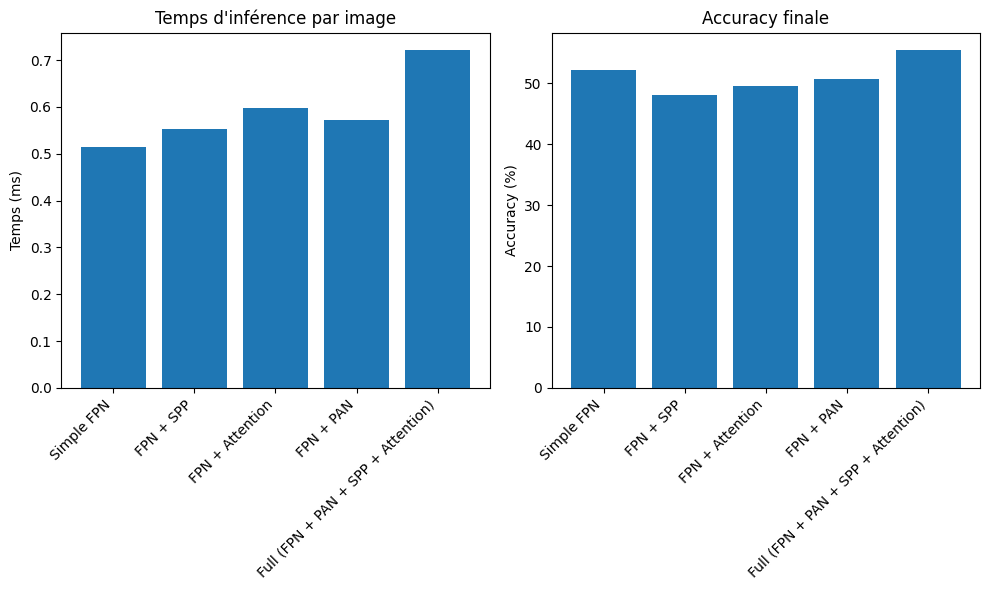

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from typing import List, Dict, Union, Tuple



class VisionModel(nn.Module):
    """Modèle de vision complet avec un backbone, un neck et une tête de classification"""
    def __init__(self, num_classes=10, neck_config=None):
        super(VisionModel, self).__init__()

        # Configuration par défaut du neck
        if neck_config is None:
            neck_config = {
                'use_fpn': True,
                'use_pan': False,
                'use_spp': True,
                'use_attention': True,
                'attention_type': 'channel',
                'attention_ratio': 16,
                'fusion_type': 'simple',
                'output_format': 'single'
            }

        # 1. Backbone (ResNet modifié)
        resnet = models.resnet50(weights='IMAGENET1K_V1')

        # Extraire les couches du ResNet
        self.layer0 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool
        )
        self.layer1 = resnet.layer1  # C2: 256 channels
        self.layer2 = resnet.layer2  # C3: 512 channels
        self.layer3 = resnet.layer3  # C4: 1024 channels
        self.layer4 = resnet.layer4  # C5: 2048 channels

        # 2. Neck (FlexiNeck)
        self.neck = FlexiNeck(
            in_channels=[256, 512, 1024, 2048],
            out_channels=256,
            **neck_config
        )

        # 3. Classification Head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def extract_features(self, x):
        """Extrait les features du backbone"""
        x = self.layer0(x)  # 64×56×56

        c2 = self.layer1(x)  # 256×56×56
        c3 = self.layer2(c2)  # 512×28×28
        c4 = self.layer3(c3)  # 1024×14×14
        c5 = self.layer4(c4)  # 2048×7×7

        return [c2, c3, c4, c5]

    def forward(self, x):
        # Extraire les features du backbone
        features = self.extract_features(x)

        # Appliquer le neck
        neck_output = self.neck(features)

        # Pour le format de sortie "single"
        if isinstance(neck_output, torch.Tensor):
            x = self.avgpool(neck_output)
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

        # Pour d'autres formats (multi_scale, pyramid)
        elif isinstance(neck_output, list):
            # Utiliser la feature map de plus haut niveau pour la classification
            x = self.avgpool(neck_output[0])
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x
        else:
            # Pour le format "pyramid" (dictionnaire)
            # Utiliser la feature map P2 (la plus détaillée)
            x = self.avgpool(neck_output["p2"])
            x = torch.flatten(x, 1)
            x = self.fc(x)
            return x

def evaluate_model(model, dataloader, device):
    """Évalue un modèle en calculant l'accuracy et le temps d'inférence"""
    model.eval()
    correct = 0
    total = 0
    inference_times = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluation"):
            images = images.to(device)
            labels = labels.to(device)

            # Mesure du temps d'inférence
            start_time = time.time()
            outputs = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)
    inference_per_image = avg_inference_time / dataloader.batch_size

    return {
        'accuracy': accuracy,
        'avg_batch_time': avg_inference_time,
        'time_per_image': inference_per_image
    }


def compare_neck_configurations(dataset='cifar10', batch_size=64, num_epochs=5):
    """Compare différentes configurations du FlexiNeck"""
    # Préparation des données (utilisation de CIFAR-10 pour simplicité)
    if dataset == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),  # ResNet attend 224x224
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

        # Utiliser un sous-ensemble pour accélérer l'expérimentation
        subset_size = 5000
        indices = torch.randperm(len(trainset))[:subset_size]
        trainset = torch.utils.data.Subset(trainset, indices)

        test_subset_size = 1000
        test_indices = torch.randperm(len(testset))[:test_subset_size]
        testset = torch.utils.data.Subset(testset, test_indices)

        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
        testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

        num_classes = 10

    # Configurations du neck à tester
    neck_configs = [
        {
            'name': 'Simple FPN',
            'config': {
                'use_fpn': True,
                'use_pan': False,
                'use_spp': False,
                'use_attention': False,
                'fusion_type': 'simple',
                'output_format': 'single'
            }
        },
        {
            'name': 'FPN + SPP',
            'config': {
                'use_fpn': True,
                'use_pan': False,
                'use_spp': True,
                'use_attention': False,
                'fusion_type': 'simple',
                'output_format': 'single'
            }
        },
        {
            'name': 'FPN + Attention',
            'config': {
                'use_fpn': True,
                'use_pan': False,
                'use_spp': False,
                'use_attention': True,
                'attention_type': 'channel',
                'attention_ratio': 16,
                'fusion_type': 'simple',
                'output_format': 'single'
            }
        },
        {
            'name': 'FPN + PAN',
            'config': {
                'use_fpn': True,
                'use_pan': True,
                'use_spp': False,
                'use_attention': False,
                'fusion_type': 'simple',
                'output_format': 'single'
            }
        },
        {
            'name': 'Full (FPN + PAN + SPP + Attention)',
            'config': {
                'use_fpn': True,
                'use_pan': True,
                'use_spp': True,
                'use_attention': True,
                'attention_type': 'channel',
                'attention_ratio': 16,
                'fusion_type': 'weighted',
                'output_format': 'single'
            }
        }
    ]

    # Résultats pour chaque configuration
    results = {}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation de l'appareil: {device}")

    # Tester chaque configuration
    for config_info in neck_configs:
        config_name = config_info['name']
        neck_config = config_info['config']

        print(f"\n--- Test de la configuration: {config_name} ---")

        # Initialiser le modèle avec la configuration actuelle
        model = VisionModel(num_classes=num_classes, neck_config=neck_config)
        model = model.to(device)

        # Définir le critère et l'optimiseur
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Entraîner le modèle
        train_accuracies = []
        test_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (inputs, labels) in enumerate(tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total
            train_accuracies.append(train_accuracy)

            # Évaluer le modèle après chaque époque
            model.eval()
            eval_results = evaluate_model(model, testloader, device)
            test_accuracies.append(eval_results['accuracy'])

            print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, Test Acc: {eval_results['accuracy']:.2f}%")

        # Évaluer le modèle final
        final_results = evaluate_model(model, testloader, device)

        # Sauvegarder les résultats
        results[config_name] = {
            'config': neck_config,
            'final_accuracy': final_results['accuracy'],
            'inference_time': final_results['time_per_image'],
            'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies
        }

        # Sauvegarder le modèle
        torch.save(model.state_dict(), f"model_{config_name.replace(' ', '_').lower()}.pth")

    # Afficher et comparer les résultats
    print("\n--- Résultats de comparaison ---")
    for config_name, result in results.items():
        print(f"\nConfiguration: {config_name}")
        print(f"Accuracy finale: {result['final_accuracy']:.2f}%")
        print(f"Temps d'inférence par image: {result['inference_time']*1000:.2f} ms")

    # Tracer les courbes d'apprentissage
    plt.figure(figsize=(12, 10))

    # Plot des accuracies d'entraînement
    plt.subplot(2, 1, 1)
    for config_name, result in results.items():
        plt.plot(range(1, num_epochs+1), result['train_accuracies'], marker='o', label=config_name)

    plt.title('Accuracy d\'entraînement')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Plot des accuracies de test
    plt.subplot(2, 1, 2)
    for config_name, result in results.items():
        plt.plot(range(1, num_epochs+1), result['test_accuracies'], marker='o', label=config_name)

    plt.title('Accuracy de test')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('learning_curves.png')

    # Plot de comparaison des temps d'inférence
    plt.figure(figsize=(10, 6))
    config_names = list(results.keys())
    inference_times = [results[name]['inference_time']*1000 for name in config_names]
    accuracies = [results[name]['final_accuracy'] for name in config_names]

    plt.subplot(1, 2, 1)
    plt.bar(config_names, inference_times)
    plt.title('Temps d\'inférence par image')
    plt.ylabel('Temps (ms)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.bar(config_names, accuracies)
    plt.title('Accuracy finale')
    plt.ylabel('Accuracy (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.savefig('comparison.png')

    return results


def main():
    """Fonction principale pour exécuter les expériences"""
    # Définir les graines pour la reproductibilité
    torch.manual_seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Vérifier la disponibilité du GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation de l'appareil: {device}")

    # Comparer différentes configurations du FlexiNeck
    results = compare_neck_configurations(
        dataset='cifar10',
        batch_size=32,
        num_epochs=5
    )

    # Afficher un résumé des résultats
    print("\n=== Résumé des résultats ===")
    best_accuracy = 0
    best_config = None
    fastest_config = None
    min_time = float('inf')

    for config_name, result in results.items():
        if result['final_accuracy'] > best_accuracy:
            best_accuracy = result['final_accuracy']
            best_config = config_name

        if result['inference_time'] < min_time:
            min_time = result['inference_time']
            fastest_config = config_name

    print(f"\nMeilleure configuration pour l'accuracy: {best_config} avec {best_accuracy:.2f}%")
    print(f"Configuration la plus rapide: {fastest_config} avec {min_time*1000:.2f} ms par image")


if __name__ == "__main__":
    main()

Utilisation de l'appareil: cuda
Utilisation de l'appareil: cuda

--- Test de la configuration: Simple FPN ---


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 1, Loss: 1.9531, Train Acc: 28.34%, Test Acc: 31.90%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 2, Loss: 1.5946, Train Acc: 38.98%, Test Acc: 33.30%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]


Epoch 3, Loss: 1.4535, Train Acc: 45.38%, Test Acc: 44.50%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 4, Loss: 1.3590, Train Acc: 48.60%, Test Acc: 49.20%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s]


Epoch 5, Loss: 1.2580, Train Acc: 53.80%, Test Acc: 52.60%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]


Epoch 6, Loss: 1.1800, Train Acc: 58.18%, Test Acc: 56.80%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]


Epoch 7, Loss: 1.1090, Train Acc: 60.34%, Test Acc: 54.10%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.70it/s]


Epoch 8, Loss: 1.0703, Train Acc: 61.06%, Test Acc: 53.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.41it/s]


Epoch 9, Loss: 1.0088, Train Acc: 63.58%, Test Acc: 58.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


Epoch 10, Loss: 0.9394, Train Acc: 66.62%, Test Acc: 66.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


Epoch 11, Loss: 0.9071, Train Acc: 68.08%, Test Acc: 63.10%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]


Epoch 12, Loss: 0.8723, Train Acc: 69.08%, Test Acc: 65.80%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s]



--- Test de la configuration: FPN + SPP ---


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Epoch 1, Loss: 1.9505, Train Acc: 28.40%, Test Acc: 24.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.35it/s]


Epoch 2, Loss: 1.6102, Train Acc: 39.24%, Test Acc: 37.90%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.16it/s]


Epoch 3, Loss: 1.5031, Train Acc: 42.96%, Test Acc: 41.80%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]


Epoch 4, Loss: 1.3748, Train Acc: 47.82%, Test Acc: 44.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]


Epoch 5, Loss: 1.3362, Train Acc: 51.40%, Test Acc: 54.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]


Epoch 6, Loss: 1.2296, Train Acc: 55.12%, Test Acc: 51.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]


Epoch 7, Loss: 1.1384, Train Acc: 58.66%, Test Acc: 54.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]


Epoch 8, Loss: 1.0765, Train Acc: 61.38%, Test Acc: 54.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


Epoch 9, Loss: 1.0194, Train Acc: 63.12%, Test Acc: 51.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


Epoch 10, Loss: 0.9804, Train Acc: 64.52%, Test Acc: 57.10%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.21it/s]


Epoch 11, Loss: 0.9548, Train Acc: 65.72%, Test Acc: 63.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]


Epoch 12, Loss: 0.9130, Train Acc: 67.50%, Test Acc: 55.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]



--- Test de la configuration: FPN + Attention ---


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch 1, Loss: 1.7910, Train Acc: 34.02%, Test Acc: 45.40%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]


Epoch 2, Loss: 1.4552, Train Acc: 46.36%, Test Acc: 40.70%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


Epoch 3, Loss: 1.3614, Train Acc: 50.58%, Test Acc: 49.30%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]


Epoch 4, Loss: 1.2694, Train Acc: 53.90%, Test Acc: 51.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]


Epoch 5, Loss: 1.1417, Train Acc: 58.44%, Test Acc: 56.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]


Epoch 6, Loss: 1.0637, Train Acc: 62.54%, Test Acc: 62.00%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.44it/s]


Epoch 7, Loss: 1.0218, Train Acc: 63.26%, Test Acc: 61.20%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]


Epoch 8, Loss: 0.9495, Train Acc: 65.92%, Test Acc: 65.40%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s]


Epoch 9, Loss: 0.8823, Train Acc: 69.46%, Test Acc: 59.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch 10, Loss: 0.8587, Train Acc: 69.56%, Test Acc: 61.10%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s]


Epoch 11, Loss: 0.8267, Train Acc: 70.96%, Test Acc: 67.20%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.47it/s]


Epoch 12, Loss: 0.7886, Train Acc: 72.20%, Test Acc: 68.10%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.28it/s]



--- Test de la configuration: FPN + PAN ---


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.24it/s]


Epoch 1, Loss: 2.0433, Train Acc: 22.98%, Test Acc: 33.20%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.15it/s]


Epoch 2, Loss: 1.6802, Train Acc: 34.70%, Test Acc: 31.10%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]


Epoch 3, Loss: 1.6436, Train Acc: 37.18%, Test Acc: 42.00%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.10it/s]


Epoch 4, Loss: 1.4964, Train Acc: 43.26%, Test Acc: 36.40%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]


Epoch 5, Loss: 1.4091, Train Acc: 47.68%, Test Acc: 46.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.20it/s]


Epoch 6, Loss: 1.3137, Train Acc: 51.36%, Test Acc: 46.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s]


Epoch 7, Loss: 1.2697, Train Acc: 52.16%, Test Acc: 39.80%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.29it/s]


Epoch 8, Loss: 1.2371, Train Acc: 53.58%, Test Acc: 52.20%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.40it/s]


Epoch 9, Loss: 1.1865, Train Acc: 55.56%, Test Acc: 48.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]


Epoch 10, Loss: 1.1521, Train Acc: 57.76%, Test Acc: 58.80%


Evaluation: 100%|██████████| 32/32 [00:04<00:00,  6.42it/s]


Epoch 11, Loss: 1.1060, Train Acc: 58.44%, Test Acc: 59.00%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


Epoch 12, Loss: 1.0837, Train Acc: 60.24%, Test Acc: 55.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.19it/s]



--- Test de la configuration: Full (FPN + PAN + SPP + Attention) ---


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]


Epoch 1, Loss: 2.0536, Train Acc: 22.58%, Test Acc: 26.90%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]


Epoch 2, Loss: 1.7201, Train Acc: 33.90%, Test Acc: 35.60%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


Epoch 3, Loss: 1.5470, Train Acc: 41.38%, Test Acc: 23.40%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]


Epoch 4, Loss: 1.4716, Train Acc: 43.92%, Test Acc: 44.40%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s]


Epoch 5, Loss: 1.3875, Train Acc: 47.90%, Test Acc: 46.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


Epoch 6, Loss: 1.3599, Train Acc: 49.46%, Test Acc: 53.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]


Epoch 7, Loss: 1.2366, Train Acc: 54.52%, Test Acc: 58.20%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


Epoch 8, Loss: 1.1690, Train Acc: 57.44%, Test Acc: 57.50%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


Epoch 9, Loss: 1.1235, Train Acc: 59.20%, Test Acc: 60.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.99it/s]


Epoch 10, Loss: 1.0483, Train Acc: 61.88%, Test Acc: 61.30%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


Epoch 11, Loss: 1.0043, Train Acc: 63.24%, Test Acc: 62.70%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]


Epoch 12, Loss: 0.9747, Train Acc: 63.90%, Test Acc: 62.80%


Evaluation: 100%|██████████| 32/32 [00:05<00:00,  5.67it/s]



--- Résultats de comparaison ---

Configuration: Simple FPN
Accuracy finale: 65.80%
Temps d'inférence par image: 0.63 ms

Configuration: FPN + SPP
Accuracy finale: 55.00%
Temps d'inférence par image: 0.59 ms

Configuration: FPN + Attention
Accuracy finale: 68.10%
Temps d'inférence par image: 0.67 ms

Configuration: FPN + PAN
Accuracy finale: 55.50%
Temps d'inférence par image: 0.63 ms

Configuration: Full (FPN + PAN + SPP + Attention)
Accuracy finale: 62.80%
Temps d'inférence par image: 0.90 ms

=== Résumé des résultats ===

Meilleure configuration pour l'accuracy: FPN + Attention avec 68.10%
Configuration la plus rapide: FPN + SPP avec 0.59 ms par image


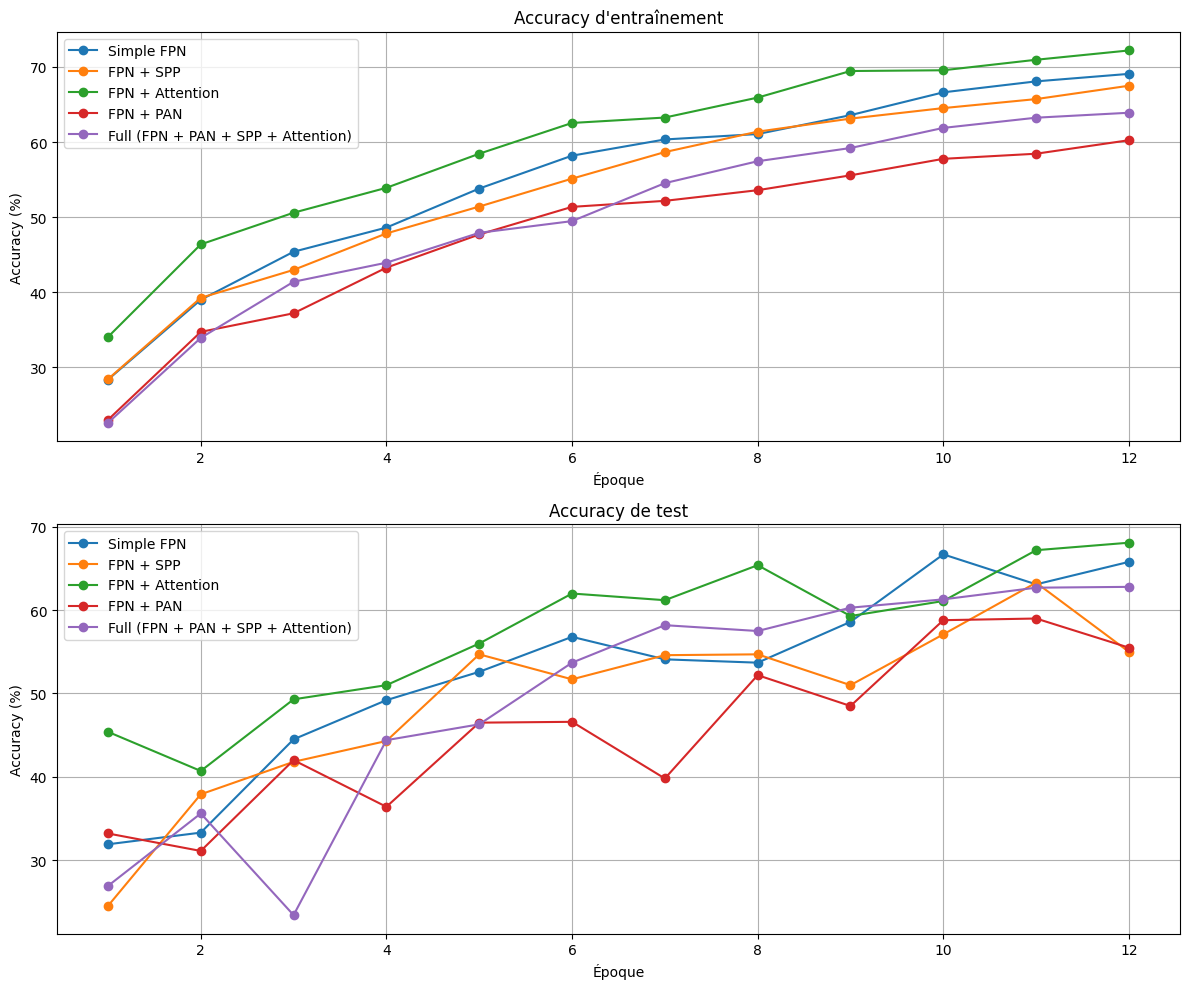

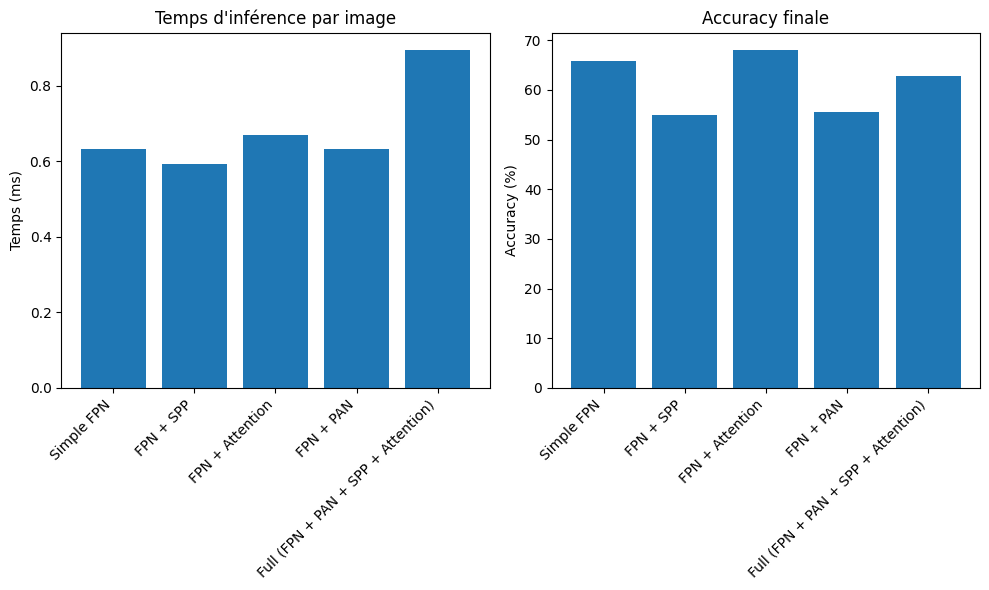

In [ ]:
def main():
    """Fonction principale pour exécuter les expériences"""
    # Définir les graines pour la reproductibilité
    torch.manual_seed(42)
    np.random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Vérifier la disponibilité du GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation de l'appareil: {device}")

    # Comparer différentes configurations du ModularNeck
    results = compare_neck_configurations(
        dataset='cifar10',
        batch_size=32,
        num_epochs=12
    )

    # Afficher un résumé des résultats
    print("\n=== Résumé des résultats ===")
    best_accuracy = 0
    best_config = None
    fastest_config = None
    min_time = float('inf')

    for config_name, result in results.items():
        if result['final_accuracy'] > best_accuracy:
            best_accuracy = result['final_accuracy']
            best_config = config_name

        if result['inference_time'] < min_time:
            min_time = result['inference_time']
            fastest_config = config_name

    print(f"\nMeilleure configuration pour l'accuracy: {best_config} avec {best_accuracy:.2f}%")
    print(f"Configuration la plus rapide: {fastest_config} avec {min_time*1000:.2f} ms par image")


if __name__ == "__main__":
    main()